In [24]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import font_manager, rc
plt.rcParams['font.family'] = 'NanumGothic'
import platform
if platform.system() == 'Windows':
    font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
    rc('font', family=font_name)
else:    
    rc('font', family='AppleGothic')

matplotlib.rcParams['axes.unicode_minus'] = False

# Warnings
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error as mae

from catboost import CatBoostRegressor
from sklearn.model_selection import cross_val_score

In [97]:
import os
path = os.path.dirname(os.getcwd())
path = os.path.join(path, "ProcessedData")
train = pd.read_csv(os.path.join(path,"merged_train.csv"))
test = pd.read_csv(os.path.join(path,"merged_test.csv"))

In [98]:
non_unique = ['전용면적','전용면적별세대수','임대보증금','임대료','임대건물구분','자격유형','공급유형']
train = train.drop(non_unique,axis=1).drop_duplicates().reset_index(drop=True)
test = test.drop(non_unique,axis=1).drop_duplicates().reset_index(drop=True)

In [99]:
train['공가수_비율'] =  train.apply(lambda x : x['공가수']/x['총세대수'],axis=1)
train['세대당_가능주차면수'] = train.apply(lambda x : x['단지내주차면수']/x['총세대수'],axis=1)
test['공가수_비율'] =  test.apply(lambda x : x['공가수']/x['총세대수'],axis=1)
test['세대당_가능주차면수'] = test.apply(lambda x : x['단지내주차면수']/x['총세대수'],axis=1)

In [100]:
train['0~19 인구수'] = train['0~19세_비율']*train['총세대수']
train['20~39 인구수'] = train['20~39세_비율']*train['총세대수']
train['40~69 인구수'] = train['40~69세_비율']*train['총세대수']
train['70세이상 인구수'] = train['70세이상_비율']*train['총세대수']

In [101]:
test['0~19 인구수'] = test['0~19세_비율']*test['총세대수']
test['20~39 인구수'] = test['20~39세_비율']*test['총세대수']
test['40~69 인구수'] = test['40~69세_비율']*test['총세대수']
test['70세이상 인구수'] = test['70세이상_비율']*test['총세대수']

In [119]:
train_one = pd.read_csv("data/train6.csv")
test_one = pd.read_csv("data/test6.csv")

X = train_one.drop(['등록차량수','단지코드'],axis=1)
y = train_one['등록차량수']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=2021,shuffle=True)

cb = CatBoostRegressor(random_state=2021,verbose=False,loss_function='MAE').fit(X_train, y_train)
pred = cb.predict(X_test)

In [120]:
prediction = train_one[['단지코드','등록차량수']]
prediction.loc[y_test.index.values,'y_pred'] = pred
prediction = prediction.dropna()
prediction['mae'] = prediction.apply(lambda x : abs(x['y_pred']-x['등록차량수']), axis=1)
prediction = pd.merge(prediction,train.drop(['도로명주소','연면적'],axis=1),how='left',on='단지코드')

prediction['score'] = prediction['mae'].apply(lambda x : 1 if x<=150 else 0)

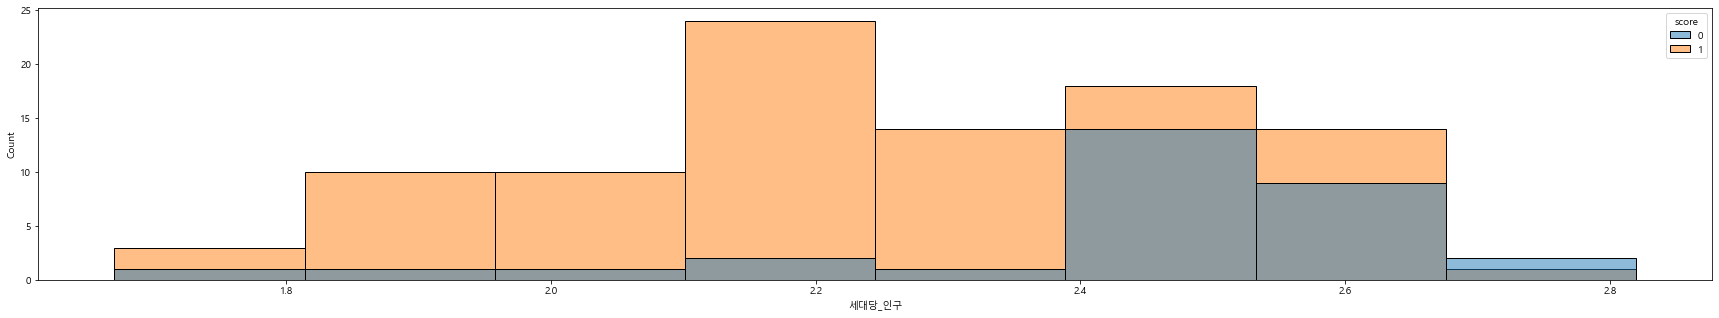

In [121]:
fig, ax = plt.subplots(figsize=(30,5))
sns.histplot(data=prediction,x='세대당_인구',hue='score')

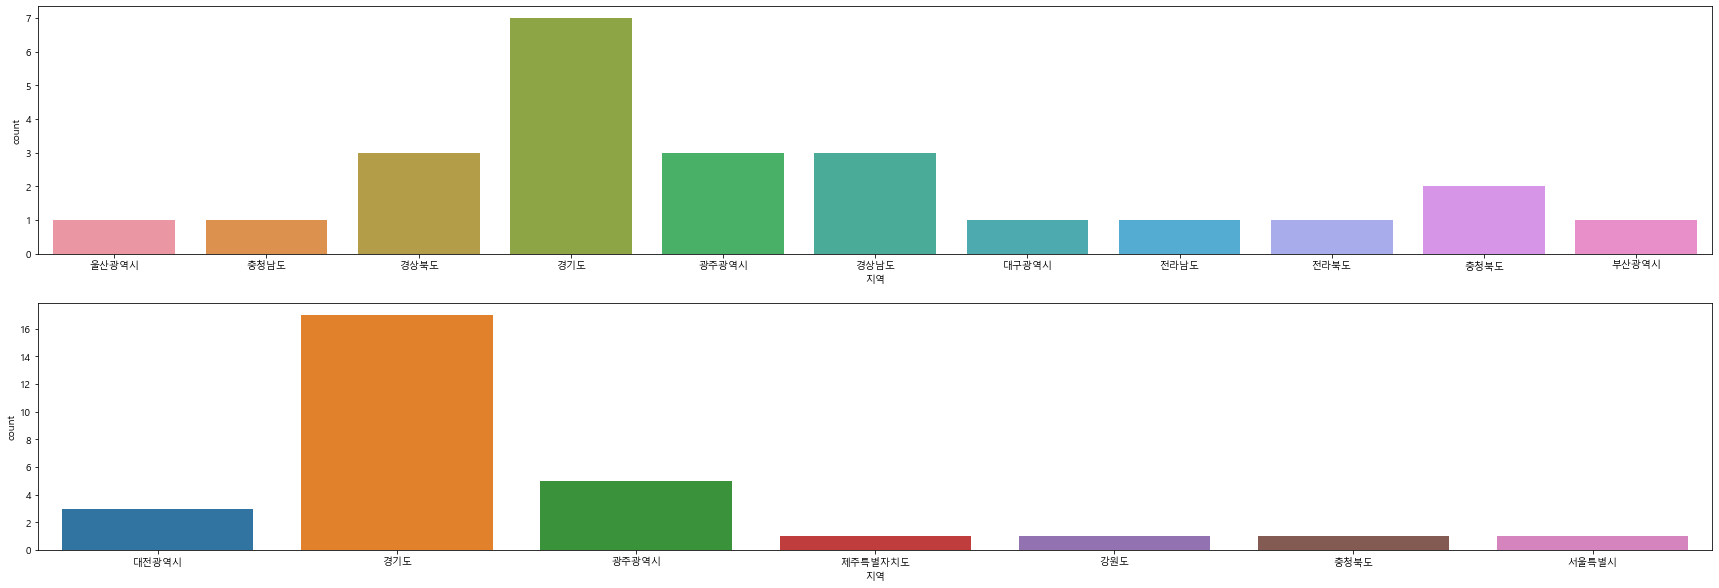

In [122]:
tmp = prediction[prediction['세대당_인구']>2.4]
fig, ax = plt.subplots(2,1,figsize=(30,10))
sns.countplot(x='지역',data=tmp[tmp['score']==0],ax=ax[0])
sns.countplot(x='지역',data=tmp[tmp['score']==1],ax=ax[1])

- 대전,제주도,강원도 제거

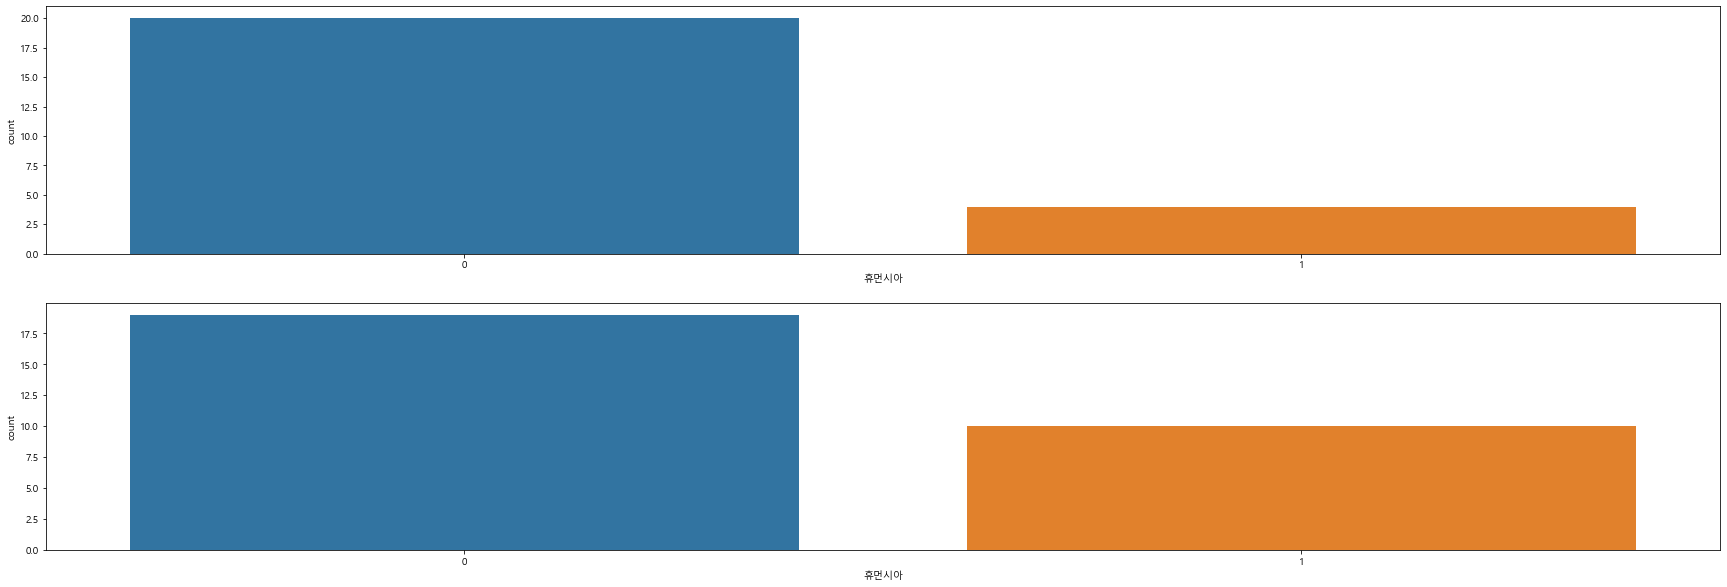

In [123]:
tmp['휴먼시아'] = tmp['단지명'].apply(lambda x : 1 if x.find("휴먼시아")!=-1 else 0 )
fig, ax = plt.subplots(2,1,figsize=(30,10))
sns.countplot(x='휴먼시아',data=tmp[tmp['score']==0],ax=ax[0])
sns.countplot(x='휴먼시아',data=tmp[tmp['score']==1],ax=ax[1])

- 휴먼시아 제거

In [118]:
tmp = train.copy()
tmp['휴먼시아'] = tmp['단지명'].apply(lambda x : 1 if x.find("휴먼시아")!=-1 else 0 )
tmp['휴먼시아'].value_counts()

0    301
1    113
Name: 휴먼시아, dtype: int64